<a href="https://colab.research.google.com/github/nishantruwari/projects/blob/main/implementing_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

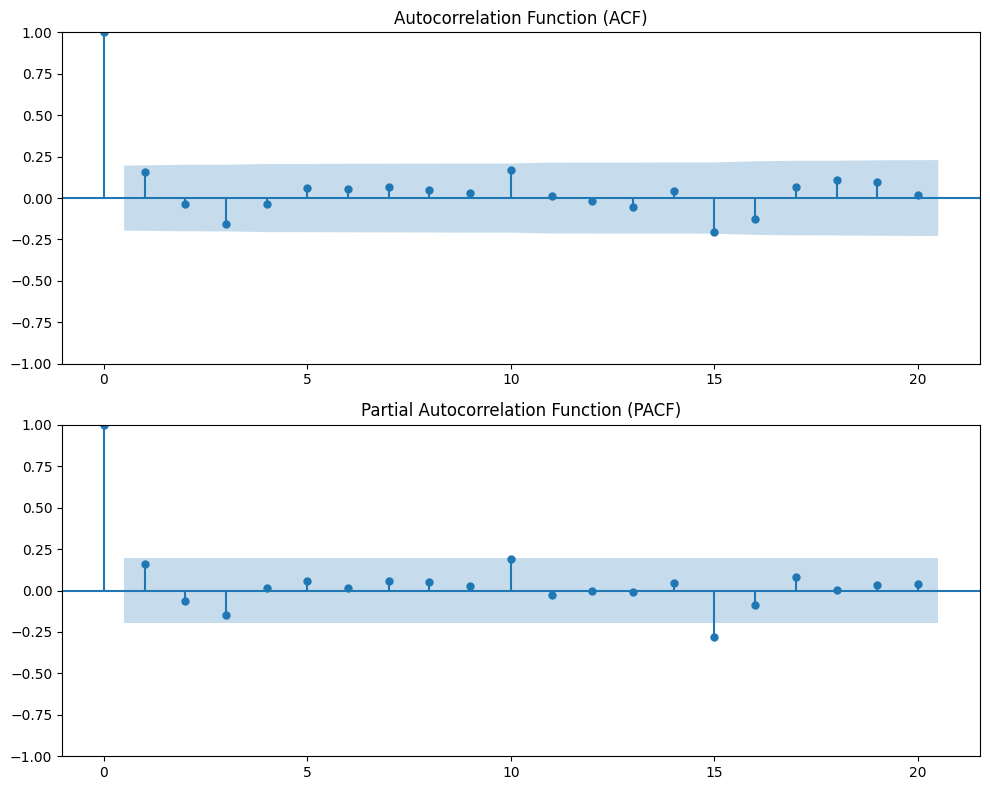

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Example time series data
data = np.random.randn(100)  # Replace with your time series data

# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(data, ax=ax[0], lags=20)
ax[0].set_title("Autocorrelation Function (ACF)")

plot_pacf(data, ax=ax[1], lags=20, method='ywm')
ax[1].set_title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
data = pd.read_csv('/content/train.csv.zip')

FileNotFoundError: [Errno 2] No such file or directory: '/content/train.csv.zip'

In [ ]:
data = np.array(data)

In [ ]:
m, n = data.shape
np.random.shuffle(data)  # Shuffle before splitting into dev and training sets

# Split the data
data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.

# Shape of X_train (m_train examples)
_, m_train = X_train.shape

In [ ]:
def init_params():
    W1 = np.random.randn(128, 784) * 0.01  # 128 neurons in the first hidden layer
    b1 = np.zeros((128, 1))
    W2 = np.random.randn(64, 128) * 0.01  # 64 neurons in the second hidden layer
    b2 = np.zeros((64, 1))
    W3 = np.random.randn(10, 64) * 0.01   # 10 outputs (one for each digit)
    b3 = np.zeros((10, 1))
    return W1, b1, W2, b2, W3, b3


In [ ]:
def leaky_relu(Z):
    return np.maximum(0, Z)

# Derivative of ReLU
def leaky_relu_deriv(Z):
    return (Z > 0).astype(float)

In [ ]:
def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))  # Avoid overflow
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

In [ ]:
def forward_prop(W1, b1, W2, b2, W3, b3, X):
    Z1 = W1.dot(X) + b1
    A1 = leaky_relu(Z1)  # Using Leaky ReLU here
    Z2 = W2.dot(A1) + b2
    A2 = leaky_relu(Z2)  # Second hidden layer with Leaky ReLU
    Z3 = W3.dot(A2) + b3
    A3 = softmax(Z3)     # Output layer
    return Z1, A1, Z2, A2, Z3, A3

In [ ]:
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    return one_hot_Y.T

In [ ]:
def backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y, m_train):
    one_hot_Y = one_hot(Y)

    # Compute derivatives for output layer
    dZ3 = A3 - one_hot_Y
    dW3 = (1 / m_train) * dZ3.dot(A2.T)
    db3 = (1 / m_train) * np.sum(dZ3, axis=1, keepdims=True)

    # Compute derivatives for second hidden layer
    dZ2 = W3.T.dot(dZ3) * leaky_relu_deriv(Z2)
    dW2 = (1 / m_train) * dZ2.dot(A1.T)
    db2 = (1 / m_train) * np.sum(dZ2, axis=1, keepdims=True)

    # Compute derivatives for first hidden layer
    dZ1 = W2.T.dot(dZ2) * leaky_relu_deriv(Z1)
    dW1 = (1 / m_train) * dZ1.dot(X.T)
    db1 = (1 / m_train) * np.sum(dZ1, axis=1, keepdims=True)

    return dW1, db1, dW2, db2, dW3, db3


In [ ]:
def update_params_with_adam(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3,
                            mW1, mb1, mW2, mb2, mW3, mb3, vW1, vb1, vW2, vb2, vW3, vb3,
                            alpha, beta1, beta2, epsilon, t):
    # Update moving averages of gradients (first moment)
    mW1 = beta1 * mW1 + (1 - beta1) * dW1
    mb1 = beta1 * mb1 + (1 - beta1) * db1
    mW2 = beta1 * mW2 + (1 - beta1) * dW2
    mb2 = beta1 * mb2 + (1 - beta1) * db2
    mW3 = beta1 * mW3 + (1 - beta1) * dW3
    mb3 = beta1 * mb3 + (1 - beta1) * db3

    # Update moving averages of squared gradients (second moment)
    vW1 = beta2 * vW1 + (1 - beta2) * (dW1**2)
    vb1 = beta2 * vb1 + (1 - beta2) * (db1**2)
    vW2 = beta2 * vW2 + (1 - beta2) * (dW2**2)
    vb2 = beta2 * vb2 + (1 - beta2) * (db2**2)
    vW3 = beta2 * vW3 + (1 - beta2) * (dW3**2)
    vb3 = beta2 * vb3 + (1 - beta2) * (db3**2)

    # Correct bias in moving averages
    mW1_corrected = mW1 / (1 - beta1**t)
    mb1_corrected = mb1 / (1 - beta1**t)
    mW2_corrected = mW2 / (1 - beta1**t)
    mb2_corrected = mb2 / (1 - beta1**t)
    mW3_corrected = mW3 / (1 - beta1**t)
    mb3_corrected = mb3 / (1 - beta1**t)

    vW1_corrected = vW1 / (1 - beta2**t)
    vb1_corrected = vb1 / (1 - beta2**t)
    vW2_corrected = vW2 / (1 - beta2**t)
    vb2_corrected = vb2 / (1 - beta2**t)
    vW3_corrected = vW3 / (1 - beta2**t)
    vb3_corrected = vb3 / (1 - beta2**t)

    # Update parameters
    W1 -= alpha * mW1_corrected / (np.sqrt(vW1_corrected) + epsilon)
    b1 -= alpha * mb1_corrected / (np.sqrt(vb1_corrected) + epsilon)
    W2 -= alpha * mW2_corrected / (np.sqrt(vW2_corrected) + epsilon)
    b2 -= alpha * mb2_corrected / (np.sqrt(vb2_corrected) + epsilon)
    W3 -= alpha * mW3_corrected / (np.sqrt(vW3_corrected) + epsilon)
    b3 -= alpha * mb3_corrected / (np.sqrt(vb3_corrected) + epsilon)

    return W1, b1, W2, b2, W3, b3, mW1, mb1, mW2, mb2, mW3, mb3, vW1, vb1, vW2, vb2, vW3, vb3



In [ ]:
def gradient_descent(X, Y, alpha, iterations, beta1, beta2, epsilon):
    # Initialize parameters
    W1, b1, W2, b2, W3, b3 = init_params()
    mW1, mb1, mW2, mb2, mW3, mb3 = np.zeros_like(W1), np.zeros_like(b1), np.zeros_like(W2), np.zeros_like(b2), np.zeros_like(W3), np.zeros_like(b3)
    vW1, vb1, vW2, vb2, vW3, vb3 = np.zeros_like(W1), np.zeros_like(b1), np.zeros_like(W2), np.zeros_like(b2), np.zeros_like(W3), np.zeros_like(b3)

    for t in range(1, iterations + 1):
        # Forward propagation
        Z1, A1, Z2, A2, Z3, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X)

        # Backward propagation
        dW1, db1, dW2, db2, dW3, db3 = backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y, X.shape[1])

        # Update parameters using Adam
        W1, b1, W2, b2, W3, b3, mW1, mb1, mW2, mb2, mW3, mb3, vW1, vb1, vW2, vb2, vW3, vb3 = update_params_with_adam(
            W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3,
            mW1, mb1, mW2, mb2, mW3, mb3, vW1, vb1, vW2, vb2, vW3, vb3,
            alpha, beta1, beta2, epsilon, t
        )

        # Print progress
        if t % 10 == 0:
            predictions = make_predictions(X, W1, b1, W2, b2, W3, b3)
            accuracy = get_accuracy(predictions, Y)
            print(f"Iteration {t}: Accuracy = {accuracy:.4f}")

    return W1, b1, W2, b2, W3, b3


In [ ]:
def make_predictions(X, W1, b1, W2, b2, W3, b3):
    _, _, _, _, _, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X)
    predictions = get_predictions(A3)
    return predictions

In [ ]:
def get_predictions(A):
    return np.argmax(A, axis=0)


In [ ]:
def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size


In [ ]:
# Initialize parameters and train
alpha = 0.001
iterations = 100
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

W1, b1, W2, b2, W3, b3 = gradient_descent(X_train, Y_train, alpha, iterations, beta1, beta2, epsilon)

# Evaluate on dev set
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2, W3, b3)
accuracy = get_accuracy(dev_predictions, Y_dev)
print(f"Dev Set Accuracy: {accuracy}")


In [ ]:

def test_prediction(index, W1, b1, W2, b2, W3, b3):
    current_image = X_train[:, index, None]
    # Pass W3 and b3 to make_predictions
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2, W3, b3)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

In [ ]:
test_prediction(0, W1, b1, W2, b2, W3 , b3)
test_prediction(1, W1, b1, W2, b2,W3 , b3)
test_prediction(2, W1, b1, W2, b2,W3 , b3)
test_prediction(3, W1, b1, W2, b2,W3 , b3)

In [ ]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2,W3,b3)
get_accuracy(dev_predictions, Y_dev)

In [ ]:
# prompt: export this model

import pickle

# Assuming W1, b1, W2, b2, W3, b3 are defined from your training

model_params = {
    'W1': W1,
    'b1': b1,
    'W2': W2,
    'b2': b2,
    'W3': W3,
    'b3': b3
}


with open('trained_model.pkl', 'wb') as f:
    pickle.dump(model_params, f)

print("Model exported to trained_model.pkl")